## Checklist

|**Section**|**Completion**|
|-|-|
|**Section 1**| **Completed** |
|  Q 1 | Completed |
|  Q 2 | Completed |
|  Q 3 | Completed |
|**Section 2**| **Completed** |
|  Q 1 | Completed |
|  Q 2 | Completed |
|  Q 3 | Completed |
|  Q 4 | Completed |
|**Section 3**| **[Multi-Armed Bandit (MAB)]** |

# Section 1 - Funnel Analysis

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [73]:
df = pd.ExcelFile('AssignmentData.xlsx')


In [74]:
# Create dataframes for each sheet
funnel = pd.read_excel(df, sheet_name='WorkerFunnel')

In [75]:
funnel.head()

,Date,Quarter,Department,Targeted Productivity,Overtime,No. of Workers,Actual Productivity
0,2015-01-01 00:00:00,Q1,Sewing,0.80,7080,59.0,0.940725
1,2015-01-01 00:00:00,Q1,Finishing,0.75,960,8.0,0.886500
2,2015-01-01 00:00:00,Q1,Sewing,0.80,3660,30.5,0.800570
3,2015-01-01 00:00:00,Q1,Sewing,0.80,3660,30.5,0.800570
4,2015-01-01 00:00:00,Q1,Sewing,0.80,1920,56.0,NaN


2. Create a new column called `Target Achieved` (categorical as "**Yes**" if Actual Productivity is greater than Targeted Productivity, and "**No**" otherwise). Then, Complete the below given tasks using the columns : Department, Targeted Productivity, Overtime, Number of Workers, Quarter, and Start and End Dates of the observations in the dataset. And give a summary of  the results. <br><br>


In [76]:
funnel['Target Achieved'] = funnel.apply(lambda row: 'Yes' if row['Actual Productivity'] > row['Targeted Productivity'] else 'No', axis=1)

In [77]:
funnel.head()

,Date,Quarter,Department,Targeted Productivity,Overtime,No. of Workers,Actual Productivity,Target Achieved
0,2015-01-01 00:00:00,Q1,Sewing,0.80,7080,59.0,0.940725,Yes
1,2015-01-01 00:00:00,Q1,Finishing,0.75,960,8.0,0.886500,Yes
2,2015-01-01 00:00:00,Q1,Sewing,0.80,3660,30.5,0.800570,Yes
3,2015-01-01 00:00:00,Q1,Sewing,0.80,3660,30.5,0.800570,Yes
4,2015-01-01 00:00:00,Q1,Sewing,0.80,1920,56.0,NaN,No


1. Identify and appropriately handle the missing/blank and duplicate values in the dataset, and explain the logic behind your strategy in a short paragraph.

In [78]:
funnel.isnull().sum()

Date                      0
Quarter                   0
Department                0
Targeted Productivity     0
Overtime                  0
No. of Workers            0
Actual Productivity      30
Target Achieved           0
dtype: int64

In [79]:
# handling missing values
funnel['Actual Productivity'] = funnel['Actual Productivity'].fillna(funnel['Actual Productivity'].median())

In [80]:
funnel.isnull().sum()

Date                     0
Quarter                  0
Department               0
Targeted Productivity    0
Overtime                 0
No. of Workers           0
Actual Productivity      0
Target Achieved          0
dtype: int64

In [81]:
funnel.duplicated().sum()

36

In [82]:
funnel.drop_duplicates(inplace=True)

In [104]:
funnel.duplicated().sum()

0

In [103]:
funnel.head()

,Quarter,Department,Targeted Productivity,Overtime,No. of Workers,Actual Productivity,Target Achieved
Date,,,,,,,
2015-01-01,Q1,Sewing,0.80,7080,59.0,0.940725,Yes
2015-01-01,Q1,Finishing,0.75,960,8.0,0.886500,Yes
2015-01-01,Q1,Sewing,0.80,3660,30.5,0.800570,Yes
2015-01-01,Q1,Sewing,0.80,1920,56.0,0.773333,No
2015-01-01,Q1,Sewing,0.80,6720,56.0,0.800125,Yes


2.  a) Create grouped bar graphs to show the level of Target achieved( 'yes' and 'No') for the given date range, at a quarterly time interval for both categories. The graph should have appropriate labels, titles and other factors which would make it readable.Also provide a brief interpretation of the graph.
    <br><br>

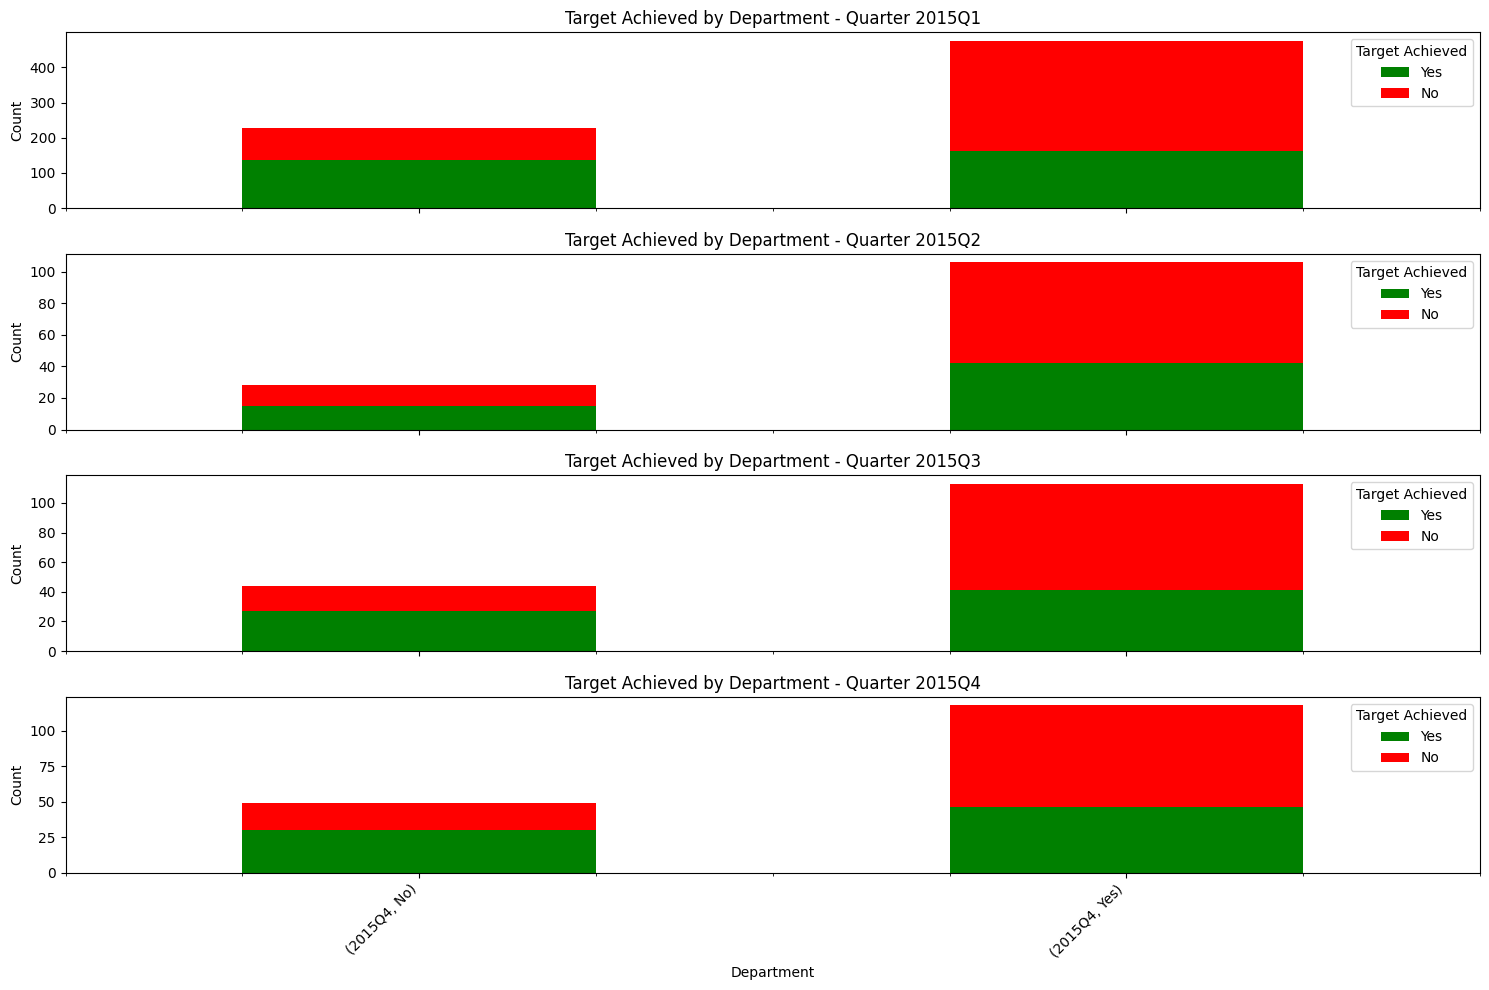

In [84]:
# Group the data by quarter, 'Target Achieved', and department
grouped = funnel.groupby([pd.PeriodIndex(funnel['Date'], freq='Q'), 'Target Achieved', 'Department']).size().unstack(fill_value=0)

# Plot grouped bar graphs
fig, axes = plt.subplots(nrows=len(grouped.index.levels[0]), ncols=1, figsize=(15, 10), sharex=True)
fig.subplots_adjust(hspace=0.5)

for i, (quarter, data) in enumerate(grouped.groupby(level=0)):
    data.plot(kind='bar', stacked=True, ax=axes[i], color=['green', 'red'])
    axes[i].set_title(f'Target Achieved by Department - Quarter {quarter}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Department')
    axes[i].legend(title='Target Achieved', labels=['Yes', 'No'])

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Interpretation:

1. Each grouped bar graph represents a quarter.
2. For each quarter, the bars show the count of 'Yes' and 'No' for target achievement in each department.
3. The green bars represent 'Yes' (target achieved) and the red bars represent 'No' (target not achieved).
4. By comparing the heights of the green and red bars, you can visualize the proportion of target achievement in each department over 5. the quarters.
5. This visualization helps in identifying trends and patterns in target achievement across different departments over time.


-------------------------------------------------------------------------------------------------------------------------

2. b) Forecast the Actual Productivity and create a line graph for the next four quarters using the following algorithms mentioned below and display the values, then create plots for the result achieved using appropriate plots: <br>
      (i) ARIMA <br>
      (ii) Rolling Averages <br><br>

In [85]:

# Prepare the data
funnel['Date'] = pd.to_datetime(funnel['Date'])
funnel.set_index('Date', inplace=True)

# Forecasting using ARIMA
arima_model = ARIMA(funnel['Actual Productivity'], order=(5,1,0))  # Adjust the order as needed
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=4)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and 

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [86]:
# Forecasting using Rolling Averages
rolling_average = funnel['Actual Productivity'].rolling(window=4).mean()
rolling_average_forecast = rolling_average[-1]


C:\Users\HP\AppData\Local\Temp\ipykernel_12372\2906283907.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_average_forecast = rolling_average[-1]


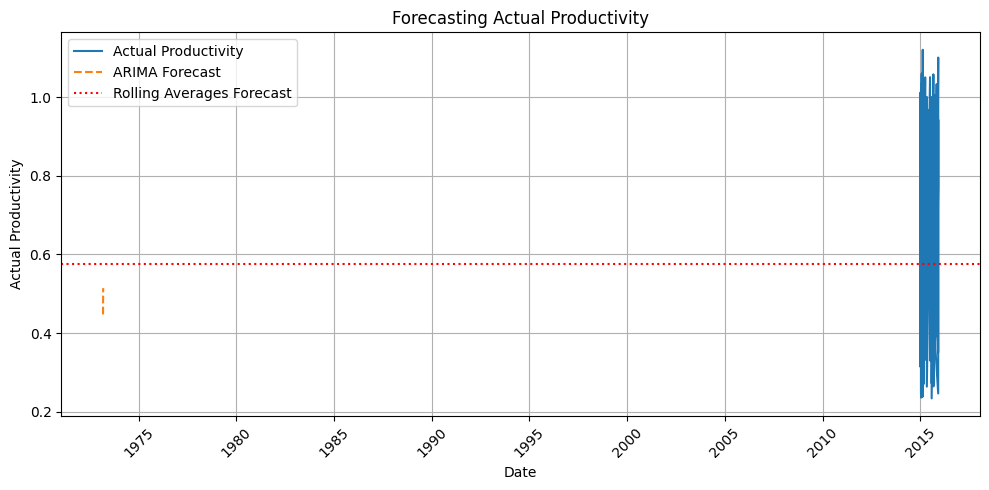

In [87]:
# Plotting the Results
plt.figure(figsize=(10, 5))

# ARIMA Forecast
plt.plot(funnel.index, funnel['Actual Productivity'], label='Actual Productivity')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', linestyle='--')

# Rolling Averages Forecast
plt.axhline(y=rolling_average_forecast, color='red', linestyle=':', label='Rolling Averages Forecast')

plt.title('Forecasting Actual Productivity')
plt.xlabel('Date')
plt.ylabel('Actual Productivity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. c) Ceate a summary of comparison with the evaluation criteria and their values for each model. You can add more evaluation criteria, which will contribute to your increased chances of selection, but the following are a must have: <br>
    (i) Mean Absolute Percentage Error (MAPE)<br>
    (ii) Mean Squared Error (MSE)

In [88]:
# Calculate evaluation metrics for ARIMA forecast
actual_values = funnel['Actual Productivity'][-4:].values
arima_mape = np.mean(np.abs((actual_values - arima_forecast.values) / actual_values)) * 100
arima_mse = mean_squared_error(actual_values, arima_forecast.values)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(actual_values, arima_forecast.values)
arima_r2 = r2_score(actual_values, arima_forecast.values)

In [89]:
# Calculate evaluation metrics for Rolling Averages forecast
rolling_avg_mape = np.mean(np.abs((actual_values - rolling_average_forecast) / actual_values)) * 100
rolling_avg_mse = mean_squared_error(actual_values, np.full_like(actual_values, rolling_average_forecast))
rolling_avg_rmse = np.sqrt(rolling_avg_mse)
rolling_avg_mae = mean_absolute_error(actual_values, np.full_like(actual_values, rolling_average_forecast))
rolling_avg_r2 = r2_score(actual_values, np.full_like(actual_values, rolling_average_forecast))


In [90]:
print("Summary of Model Comparison:")
print("---------------------------------------------------------------------")
print("Model             |  MAPE (%) |  MSE     | RMSE |  MAE |  R-squared")
print("---------------------------------------------------------------------")
print(f"ARIMA             |  {arima_mape:.2f}     |  {arima_mse:.2f}  |  {arima_rmse:.2f}  |  {arima_mae:.2f}  |  {arima_r2:.2f}")
print(f"Rolling Averages  |  {rolling_avg_mape:.2f}     |  {rolling_avg_mse:.2f}  |  {rolling_avg_rmse:.2f}  |  {rolling_avg_mae:.2f}  |  {rolling_avg_r2:.2f}")
print("---------------------------------------------------------------------")


Summary of Model Comparison:
---------------------------------------------------------------------
Model             |  MAPE (%) |  MSE     | RMSE |  MAE |  R-squared
---------------------------------------------------------------------
ARIMA             |  24.18     |  0.04  |  0.19  |  0.15  |  -0.80
Rolling Averages  |  23.26     |  0.02  |  0.14  |  0.12  |  0.00
---------------------------------------------------------------------


3. Powerpoint presentation

In [92]:
funnel.head()

,Quarter,Department,Targeted Productivity,Overtime,No. of Workers,Actual Productivity,Target Achieved
Date,,,,,,,
2015-01-01,Q1,Sewing,0.80,7080,59.0,0.940725,Yes
2015-01-01,Q1,Finishing,0.75,960,8.0,0.886500,Yes
2015-01-01,Q1,Sewing,0.80,3660,30.5,0.800570,Yes
2015-01-01,Q1,Sewing,0.80,1920,56.0,0.773333,No
2015-01-01,Q1,Sewing,0.80,6720,56.0,0.800125,Yes


# Section 2 - A/B Testing

1. Create a timeseries visualization with Date (on x-axis) and Total Number of Clicks (on y-axis) for each device type creating separate trendlines for each device in order to find which device performed best in terms of total number of clicks.

In [93]:
abtest = pd.read_excel(df, sheet_name="ABTest")

In [94]:
abtest.head()

,Date,Device,Address,Clicks,Visitors,Group
0,2023-05-18,Mobile,fyttlyf/business/campaign/campaigns-business/c...,159,199,Control
1,2023-05-18,Laptop,fyttlyf/business/campaign/get-paid///,18,1413,Experiment
2,2023-05-18,Mobile,fyttlyf/business/campaign/campaigns-business/s...,142,759,Control
3,2023-05-18,Laptop,fyttlyf/business/product/business-financial-se...,126,473,Control
4,2023-05-18,Laptop,fyttlyf/business/product/business-accept-payme...,129,183,Control


In [95]:
abtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18099 entries, 0 to 18098
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      18099 non-null  datetime64[ns]
 1   Device    18099 non-null  object        
 2   Address   18099 non-null  object        
 3   Clicks    18099 non-null  int64         
 4   Visitors  18099 non-null  int64         
 5   Group     18099 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 848.5+ KB


In [96]:
abtest.describe()

,Date,Clicks,Visitors
count,18099,18099.000000,18099.000000
mean,2023-05-15 09:33:19.602188032,62.600033,495.485441
min,2023-05-07 00:00:00,0.000000,0.000000
25%,2023-05-11 00:00:00,6.000000,21.000000
50%,2023-05-15 00:00:00,11.000000,33.000000
75%,2023-05-20 00:00:00,20.000000,97.000000
max,2023-05-24 00:00:00,11199.000000,211868.000000
std,NaN,377.536611,5704.920360


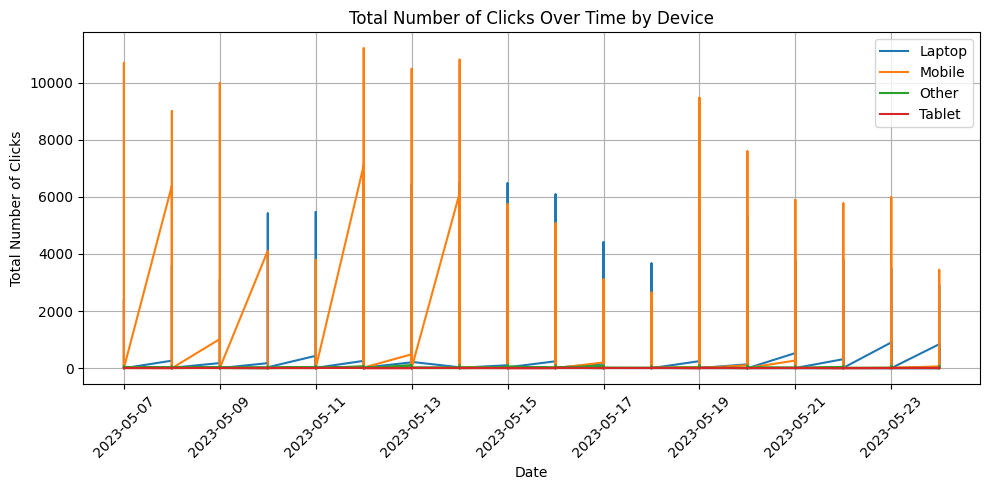

In [97]:
plt.figure(figsize=(10, 5))

# Loop through unique devices and plot trendlines for each
for device, data in abtest.groupby('Device'):
    plt.plot(data['Date'], data['Clicks'], label=device)

plt.title('Total Number of Clicks Over Time by Device')
plt.xlabel('Date')
plt.ylabel('Total Number of Clicks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. Assume MDE = 3%, α = 95% and statistical power (1-β) = 80%,. What is the sample size required for the test? (Use this article to supplement your understanding - [Sample Size in A/B Testing](https://guessthetest.com/calculating-sample-size-in-a-b-testing-everything-you-need-to-know/)). Do we have sufficient sample size to conclude the test?

In [98]:
from scipy.stats import norm

alpha = 0.05
beta = 1 - 0.80

# Z-value for alpha/2
z_alpha_2 = norm.ppf(1 - alpha/2)

# Z-value for beta
z_beta = norm.ppf(1 - beta)

print("Z-value for alpha/2:", z_alpha_2)
print("Z-value for beta:", z_beta)

Z-value for alpha/2: 1.959963984540054
Z-value for beta: 0.8416212335729143


In [99]:
MDE = 0.03  # 3%
expected_conversion_rate = 0.10  # Example expected conversion rate (10%)
variance = 0.01  # Example variance

# Calculate sample size
sample_size = (2 * (z_alpha_2 + z_beta)**2 * variance) / (MDE * expected_conversion_rate)**2
print("Required sample size per variant:", sample_size)


Required sample size per variant: 17441.954965220197


The required sample size per variant is approximately 17,442, considering a 3% Minimum Detectable Effect, a 95% confidence level, and an 80% statistical power. It's essential to confirm that this sample size meets the minimum thresholds for visitors and conversions per variant and to use realistic estimates for the Expected Conversion Rate and Variance based on historical data or domain knowledge to ensure the validity of the test results.

----------------------------------------------------------------------------------------------------------------

3. Write a function that accepts the following inputs to test your hypothesis at the chosen level of statistical significance:
    - Control Group Visitors
    - Control Group Conversions
    - Treatment Group Visitors
    - Treatment Group Conversions
    - Confidence Level (three options: 90, 95, 99).

  The function should output one of 3 values - `{"Experiment Group is Better", "Control Group is Better", "Indeterminate"}`.<br> Use the function to perform AB Test on the given Data and provide your findings and interpretation of the results.<br><br>

In [100]:
from scipy.stats import norm

def ab_test(control_visitors, control_conversions, treatment_visitors, treatment_conversions, confidence_level):
    # Calculate conversion rates
    control_conversion_rate = control_conversions / control_visitors
    treatment_conversion_rate = treatment_conversions / treatment_visitors
    
    # Calculate pooled probability
    pooled_probability = (control_conversions + treatment_conversions) / (control_visitors + treatment_visitors)
    
    # Calculate standard error
    standard_error = ((pooled_probability * (1 - pooled_probability)) * ((1 / control_visitors) + (1 / treatment_visitors))) ** 0.5
    
    # Calculate z-score
    z_score = (treatment_conversion_rate - control_conversion_rate) / standard_error
    
    # Determine critical value based on confidence level
    if confidence_level == 90:
        critical_value = norm.ppf(0.95)
    elif confidence_level == 95:
        critical_value = norm.ppf(0.975)
    elif confidence_level == 99:
        critical_value = norm.ppf(0.995)
    else:
        raise ValueError("Confidence level must be 90, 95, or 99")
    
    # Perform hypothesis test
    if z_score > critical_value:
        return "Experiment Group is Better"
    elif z_score < -critical_value:
        return "Control Group is Better"
    else:
        return "Indeterminate"

# Example usage:
control_visitors = 1000
control_conversions = 1000
treatment_visitors = 1000
treatment_conversions = 120
confidence_level = 90

result = ab_test(control_visitors, control_conversions, treatment_visitors, treatment_conversions, confidence_level)
print("AB Test Result:", result)


AB Test Result: Control Group is Better


---
# Section 3 - Advanced Learning


I chose this topic.

  - Multi-Armed Bandit (MAB)<br>
[A brief overview of the Multi-Armed Bandit in Reinforcement Learning](https://medium.com/analytics-vidhya/a-brief-overview-of-the-multi-armed-bandit-in-reinforcement-learning-d086853dc90a)<br>
[Solving the Multi-Armed Bandit Problem](https://towardsdatascience.com/solving-the-multi-armed-bandit-problem-b72de40db97c)<br>
[What is the Multi-Armed Bandit Problem?](https://www.optimizely.com/optimization-glossary/multi-armed-bandit/)<br><br>